# This notebook presents an analysis of [California Traffic Collision Data from SWITRS](https://www.kaggle.com/datasets/alexgude/california-traffic-collision-data-from-switrs). 

## Introduction

### **Data**
The data is made available on Kaggle as a SQLite database. The SQLite database file size is ~10GB. This relational database contains 4 tables:
- *case_ids*: Case IDs and Year; 9.4 million rows
- *collisions*: Information about individual cases; 9.4 million rows
- *parties*: Information about the parties involved; 18.7 million rows
- *victims*: Information about the accident victims: 9.6 million rows.
A more detailed description of the tables can be found [here](https://www.kaggle.com/datasets/alexgude/california-traffic-collision-data-from-switrs).

### **Tools** 
This analysis was conducted using SQL Queries and plots using the Plotly library. The interface used was python (SQLite3 library). 


### Import libraries and define queryExecute function for displaying queries

In [1]:
# Install packages in requirements.txt file in repository
import sqlite3
import pprintpp
import time
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import kaleido
pio.renderers.default = "svg"
%matplotlib inline

In [2]:
path = "C:\\Users\\varun.singh\\Music\dN\\7643\\Downloaded Lectures\\SWITRS DB\\" # replace with path to local folder to SQLite db.

In [3]:
conn = sqlite3.connect(path + "switrs.sqlite")

In [20]:
def queryExecute(q):
    st = time.time()
    
    cursor = conn.cursor()
    cursor.execute(q)
    
    et = time.time()
    t = et-st
    
    print('Query Execution time:', time.strftime("%M:%S", time.localtime(t)), "min:sec")
    
    return cursor

### Trend of accidents and fatalities by year 
This section generates query results for accidents and fatal accidents grouped by year and plots them on a bar chart.

In [32]:
query = "SELECT strftime('%Y', collision_date) as year,\
                COUNT(case_id) as no_accidents,\
                SUM(killed_victims) as total_fatalities\
        FROM collisions\
        WHERE strftime('%Y', collision_date) <> '2021'\
        GROUP BY year\
        ORDER BY year ASC;"
res = queryExecute(query)
df_fetch = res.fetchall()
print("Query Result")
df = pd.DataFrame(df_fetch, columns = [description[0] for description in res.description])

display(df)

Query Execution time: 00:28 min:sec
Query Result


,year,no_accidents,total_fatalities
0,2001,522562,3926
1,2002,544741,4089
2,2003,538954,4225
3,2004,538295,4094
4,2005,532725,4304
5,2006,498846,4002
6,2007,501908,3967
7,2008,452595,3401
8,2009,426228,3076
9,2010,416490,2739


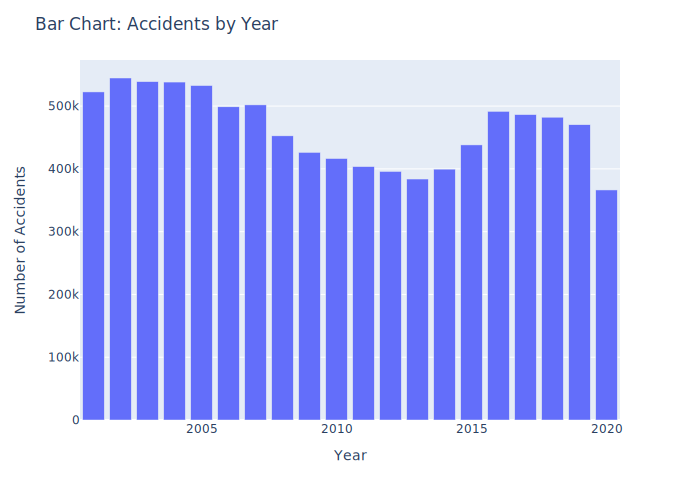

In [33]:
arr = np.array(df_fetch)
arr = arr.astype('int32')

f = px.bar(x=arr[:,0], y=arr[:,1])

f.update_layout(
    title='Bar Chart: Accidents by Year',
    xaxis_title="Year",
    yaxis_title="Number of Accidents")


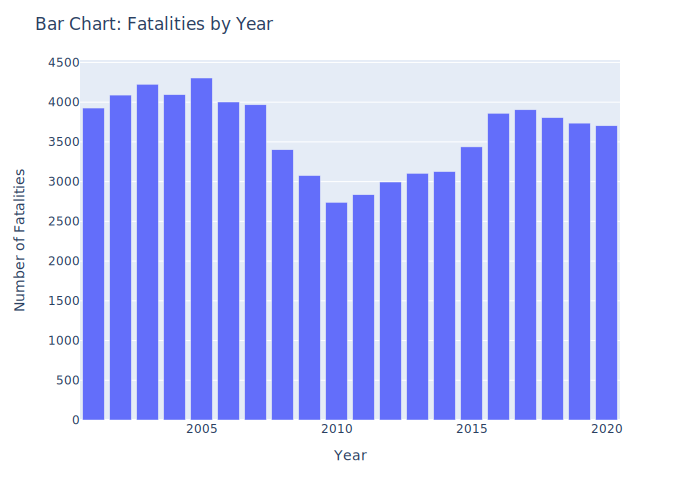

In [34]:
f = px.bar(x=arr[:,0], y=arr[:,2])

f.update_layout(
    title='Bar Chart: Fatalities by Year',
    xaxis_title="Year",
    yaxis_title="Number of Fatalities")
f.show()

The plots above suggest that both the total number of accidents and fatal accidents are trending down over the 20 year period (2001-2020) in California.

### Do seat belts help in reducing fatal accidents?

This section creates a view 'vic' which reduces the number of categories in column 'victim_degree_of_injury' and classifies the injuries into 2 categories: Fatality and Injury. This view is then joined with victims table to produce the final result.

In [24]:
# Create view for next query
query = "CREATE VIEW IF NOT EXISTS vic AS\
         SELECT victims.id,\
                CASE victims.victim_degree_of_injury WHEN 'killed' THEN 'Fatality' ELSE 'Injury' END AS accident_outcome\
         FROM victims;"
res = queryExecute(query)

query = "SELECT victims.victim_safety_equipment_1,\
                SUM(CASE vic.accident_outcome WHEN 'Fatality' THEN 1 ELSE 0 END) AS Fatalities,\
                SUM(CASE vic.accident_outcome WHEN 'Injury' THEN 1 ELSE 0 END) AS Injuries,\
                ROUND((SUM(CASE vic.accident_outcome WHEN 'Fatality' THEN 1 ELSE 0 END))*100/\
                     (CAST(SUM(CASE vic.accident_outcome WHEN 'Fatality' THEN 1 ELSE 0 END)+\
                     SUM(CASE vic.accident_outcome WHEN 'Injury' THEN 1 ELSE 0 END) AS FLOAT)),3)\
                     AS percent_fatalities\
         FROM victims INNER JOIN vic ON vic.id = victims.id\
         WHERE (victim_safety_equipment_1 = 'lap/shoulder harness used' OR victim_safety_equipment_1 = 'lap/shoulder harness not used')\
         GROUP BY victim_safety_equipment_1;"
res = queryExecute(query)
df_fetch = res.fetchall()
print("Query Result")
df = pd.DataFrame(df_fetch, columns = [description[0] for description in res.description])
display(df)

Query Execution time: 00:00 min:sec


Query Execution time: 00:31 min:sec
Query Result


,victim_safety_equipment_1,Fatalities,Injuries,percent_fatalities
0,lap/shoulder harness not used,3204,102028,3.045
1,lap/shoulder harness used,18207,3842037,0.472


From the above result, ~3% percent of accidents in which seatbelts are not used are fatal. In contrast 0.5% of accidents are fatal if seatbelts are used. So an accident is 6 times more likely to turn fatal if seatbelts are not used.

### Number of accidents by each sobriety category

In [25]:
query = "SELECT parties.party_sobriety as sobriety_category,\
         COUNT(parties.case_id) AS no_accidents,\
         COUNT(parties.case_id)*1.0/(SELECT COUNT(case_id) FROM parties\
                                    WHERE (parties.party_sobriety <> 'None' AND\
                                    parties.party_sobriety <> 'not applicable' AND\
                                    parties.party_type = 'driver'))\
         AS proportion\
         FROM parties\
         WHERE (parties.party_sobriety <> 'None' AND\
                parties.party_sobriety <> 'not applicable' AND\
                parties.party_type = 'driver')\
         GROUP BY sobriety_category\
         ORDER BY proportion DESC;"
res = queryExecute(query)
df_fetch = res.fetchall()
print("Query Result")
df = pd.DataFrame(df_fetch, columns = [description[0] for description in res.description])

display(df)

Query Execution time: 00:56 min:sec
Query Result


,sobriety_category,no_accidents,proportion
0,had not been drinking,13690165,0.839656
1,impairment unknown,1688221,0.103543
2,"had been drinking, under influence",682956,0.041888
3,"had been drinking, impairment unknown",129690,0.007954
4,"had been drinking, not under influence",113451,0.006958


### Which month of the year has highest number of DUI related accidents?

In [26]:
query = "SELECT COUNT(parties.case_id)/20.0 AS no_accidents,\
                strftime('%m', collision_date) as month\
         FROM parties LEFT JOIN collisions on parties.case_id = collisions.case_id\
         WHERE (parties.party_sobriety = 'had been drinking, under influence'\
                AND strftime('%Y', collision_date) <> '2021')\
         GROUP BY month\
         ORDER BY month ASC;"
res = queryExecute(query)
df_fetch = res.fetchall()
print("Query Result")
df = pd.DataFrame(df_fetch, columns = [description[0] for description in res.description])
display(df)

Query Execution time: 01:26 min:sec
Query Result


,no_accidents,month
0,2738.15,01
1,2707.10,02
2,2914.35,03
3,2767.45,04
4,2912.95,05
5,2814.55,06
6,2924.80,07
7,2917.80,08
8,2811.85,09
9,3018.20,10


As evident above, the last 3 months of the year record the highest average DUI related accidents. 

The next query takes a closer look at the last 3 months of the year.

### DUI accidents by week for last 14 weeks of the year

In [27]:
query = "SELECT COUNT(parties.case_id)/20.0 AS no_dui_accidents,\
                strftime('%W', collision_date) as week_of_year\
         FROM parties LEFT JOIN collisions on parties.case_id = collisions.case_id\
         WHERE (parties.party_sobriety = 'had been drinking, under influence'\
                AND week_of_year > '39'\
                AND strftime('%Y', collision_date) <> '2021')\
         GROUP BY week_of_year\
         ORDER BY week_of_year ASC;"
#AND strftime('%m', collision_date) = '12'\
res = queryExecute(query)
df_fetch = res.fetchall()
print("Query Result")
df = pd.DataFrame(df_fetch, columns = [description[0] for description in res.description])
display(df)

Query Execution time: 00:18 min:sec
Query Result


,no_dui_accidents,week_of_year
0,662.45,40
1,690.10,41
2,684.75,42
3,707.75,43
4,681.75,44
5,688.20,45
6,667.05,46
7,696.25,47
8,670.25,48
9,715.75,49


A few weeks towards the end of the year have notable spikes. 43rd week (end of October) and 49th to 51st weeks (end of November to mid December) are the worst when it comes to DUI related accidents.

### DUI accidents on day of the week

In [28]:
query = "SELECT COUNT(parties.case_id) AS no_dui_accidents,\
                CASE CAST (strftime('%w', collision_date) as integer)\
                              WHEN 0 THEN 'Sunday'\
                              WHEN 1 THEN 'Monday'\
                              WHEN 2 THEN 'Tuesday'\
                              WHEN 3 THEN 'Wednesday'\
                              WHEN 4 THEN 'Thursday'\
                              WHEN 5 THEN 'Friday'\
                              ELSE 'Saturday' END AS day_of_week\
         FROM parties LEFT JOIN collisions on parties.case_id = collisions.case_id\
         WHERE (parties.party_sobriety == 'had been drinking, under influence'\
         AND strftime('%Y', collision_date) <> '2021')\
         GROUP BY day_of_week\
         ORDER BY no_dui_accidents DESC;"
res = queryExecute(query)
df_fetch = res.fetchall()
print("Query Result")
df = pd.DataFrame(df_fetch, columns = [description[0] for description in res.description])
display(df)

Query Execution time: 00:19 min:sec
Query Result


,no_dui_accidents,day_of_week
0,159133,Saturday
1,157180,Sunday
2,105938,Friday
3,74155,Thursday
4,69990,Monday
5,65474,Wednesday
6,60258,Tuesday


As expected, weekends share the majority of DUI related accidents with Saturday being the week day with largest number of DUI related accidents.

### Types of collisions in DUI accidents.
The next two queries try to shed light on the type of collisions in case of DUI related accidents and compares it to the type of collisions for all accidents.

In [29]:
query = "SELECT COUNT(parties.case_id) AS no_dui_accidents,\
                type_of_collision\
         FROM parties LEFT JOIN collisions on parties.case_id = collisions.case_id\
         WHERE (parties.party_sobriety == 'had been drinking, under influence')\
         GROUP BY type_of_collision\
         ORDER BY no_dui_accidents DESC\
         LIMIT 5;"
res = queryExecute(query)
df_fetch = res.fetchall()
print("Query Result")
df = pd.DataFrame(df_fetch, columns = [description[0] for description in res.description])
display(df)

Query Execution time: 00:17 min:sec
Query Result


,no_dui_accidents,type_of_collision
0,242844,hit object
1,174492,rear end
2,103567,sideswipe
3,70599,broadside
4,48043,head-on


### Top 5 types of collisions in all accidents

In [30]:
query = "SELECT COUNT(parties.case_id) AS no_accidents,\
                type_of_collision\
         FROM parties LEFT JOIN collisions on parties.case_id = collisions.case_id\
         GROUP BY type_of_collision\
         ORDER BY no_accidents DESC\
         LIMIT 5;"
res = queryExecute(query)
df_fetch = res.fetchall()
print("Query Result")
df = pd.DataFrame(df_fetch, columns = [description[0] for description in res.description])
display(df)

Query Execution time: 01:34 min:sec
Query Result


,no_accidents,type_of_collision
0,7233983,rear end
1,3883765,broadside
2,3597000,sideswipe
3,1722323,hit object
4,818608,head-on


It is interesting to note the difference in collision types. In case of DUI accidents, largest number of collisions involve hitting an object. Overall, the major type of collision is rear ending. Broadside collisions or the T-bone collisions come in second over all accidents which takes the 4th place in the DUI related collisions.

In [4]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table_name in tables:
    table_name = table_name[0]
    #table = pd.read_sql_query("SELECT * from %s" % table_name, conn)
    print(table_name)
cursor.close()

case_ids
collisions
victims
parties


In [6]:
import pyspark

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
           .config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.34.0')\
           .getOrCreate()

caseid_df = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='case_ids',
                 url='jdbc:sqlite:'+path.db)\
        .load()

RuntimeError: Java gateway process exited before sending its port number